In [1]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection

According to Kohonen, we can do about 50 datapoints per node. For 3.5k that means maybe 60-80 nodes.
I want a 5x4 resolution for display reasons, so maybe 10x8 nodes?

In [2]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 6625.14it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [3]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [4]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'banana', 'tropical', 'cherry', 'pineapple', 'fruity', 'sweet'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [14]:
def flatten(mtrx):
    return mtrx.reshape((mtrx.shape[0]*mtrx.shape[1],-1)).squeeze()

class SOM(object):
    def __init__(self,width,height,gauss=10,decay=.99,use_onehot=True):
        if use_onehot:
            # Select a random index to use as the hot element.
            idxs = torch.randint(low=0,high=len(all_notes),size=(width,height))
            # Convert to one hot of shape.
            self.vectors = torch.nn.functional.one_hot(idxs,num_classes=len(all_notes)).float()
        else:
            self.vectors = torch.rand(size=(width,height,len(all_notes))).float()
        
        map_x_idx, map_y_idx = torch.meshgrid(torch.arange(start=0,end=width), torch.arange(start=0,end=height), indexing='ij')
        self.map_idx = torch.stack([map_x_idx,map_y_idx],dim=-1)

        self.gauss = gauss
        self.decay = decay

        self.vectors = flatten(self.vectors)
        self.map_idx = flatten(self.map_idx)

    def do_decay(self):
        self.gauss *= self.decay

    def get_activations(self,encoding):
        # Activation is 1 / Euclidian(vectors, encoding).
        # The closer a vector is to the encoding, the higher the activation.
        return 1/(self.vectors-encoding).square().sum(dim=-1).sqrt()

    def get_bmu(self,encoding):
        actvtn = self.get_activations(encoding)
        # Especially at the beginning of training, there may be a larger amount
        # of vectors that are equidistant to the encoding. 
        bmu_idxs = (actvtn==torch.max(actvtn)).nonzero()
        # In order to prevent embedding collapse, we select one randomly as the bmu.
        selected = np.random.randint(low=0,high=len(bmu_idxs))
        return bmu_idxs[selected]

    def mean_encoding_by_bmu(self,encodings,bmus):
        # https://stackoverflow.com/questions/56154604/groupby-aggregate-mean-in-pytorch/56155805#56155805
        M = torch.zeros(len(self.vectors), len(encodings))
        M[bmus, torch.arange(len(encodings))] = 1
        M = torch.nn.functional.normalize(M, p=1, dim=1)
        return torch.mm(M, encodings)

    def get_distances(self):
        # Distance from each node to every other node
        xy_dist = self.map_idx.unsqueeze(0) - self.map_idx.unsqueeze(1)
        return torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))

    def update_factor(self,bmus):
        dists = self.get_distances()
        # Gaussian distribution centered on BMU of width 2^gauss.
        h_ji = torch.exp(torch.neg(torch.div(dists.square(), 2*self.gauss**2)))
        bmu_count_by_idx = torch.bincount(bmus, minlength=len(self.map_idx))
        # Unsqueeze the first dimension of the counts so that the update factor
        # for i to j is weighted based on occurences of j.
        return bmu_count_by_idx.unsqueeze(0)*h_ji
        
    def update_batch(self,encodings):
        bmus = torch.cat([mm.get_bmu(e) for e in encodings])
        weighted_h_ji = self.update_factor(bmus)
        weighted_x_mj = self.mean_encoding_by_bmu(encodings,bmus)
        self.vectors = torch.mm(weighted_h_ji, weighted_x_mj)

mm = SOM(3,2)
encodings = torch.stack([mol["encoding"] for mol in molecules[:10]])
mm.update_batch(encodings)

In [9]:
train_mols, test_mols = sklearn.model_selection.train_test_split(molecules)

def do_train(config,verbose=False):
    som = SOM(width=config["width"],
              height=config["height"],
              gauss=config["gauss"],
              decay=config["decay"],
              use_onehot=config["onehot"])
    
    encodings = torch.stack([mol["encoding"] for mol in molecules])
        
    for _ in tqdm.tqdm(range(config["batches"]),smoothing=0, disable=not verbose):
        som.update_batch(train_encodings)
        losses.append(som.score(test_encodings))

    return som

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.72it/s]


[tensor(5.0965), tensor(5.0965), tensor(5.0965), tensor(5.0965), tensor(5.0965), tensor(5.0965), tensor(5.0965), tensor(5.0965), tensor(5.0965), tensor(5.0965)]
fruity tensor([72])
green tensor([72])
sweet tensor([72])
floral tensor([72])
woody tensor([72])
herbal tensor([72])
fresh tensor([72])
fatty tensor([72])
waxy tensor([72])
spicy tensor([72])


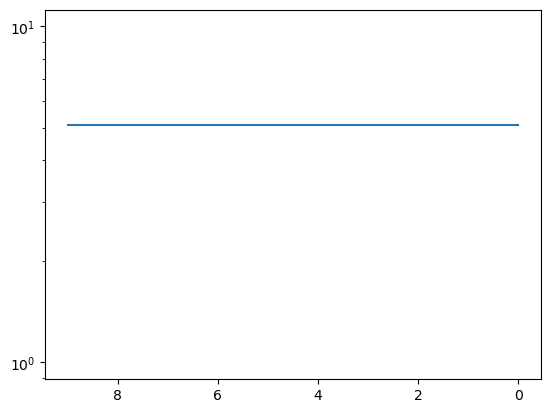

tensor(5.0965)


In [13]:
som = do_train({'width': 5*2, 'height': 4*2, 'batches': 10,"gauss":5, "decay": .99, "onehot": True},verbose=True)
for n, f in all_notes.most_common(10):
    print(n,som.get_bmu(multi_hot([n])))
    

In [ ]:
def flatten(mtrx):
    return mtrx.reshape((mtrx.shape[0]*mtrx.shape[1],-1)).squeeze()

def plot(title,encoding,as_size,factor=1,thresh=1e-5,activations=None):
    bmu = som.get_bmu(encoding)
    if not torch.is_tensor(activations):
        activations = som.get_activations(encoding)
    
    act = flatten(activations)
    minv, maxv = act.min().numpy(), act.max().numpy()
    
    pos = flatten(som.map_idx).numpy()
    
    if as_size:
        # For very very small values, matplotlib will underflow and draw circles where it should draw tiny circles.
        act = torch.nn.functional.threshold(act,thresh,0)
        plt.scatter(pos[:,0],pos[:,1],s=factor*act.numpy())
    else:
        plt.scatter(pos[:,0],pos[:,1],c=factor*act.numpy())
        plt.set_cmap('PiYG_r')
        plt.colorbar()
        # cbar.lim(minv,maxv)

    plt.title(f"{title}\nBMU of {bmu.numpy()} w/ value = {activations[bmu[0],bmu[1]]}. Range = ({minv:.2f}, {maxv:.2f})")


In [ ]:
plot(f"Map for {molecules[0]['name']} w/ notes = {molecules[0]['notes']}",
     molecules[0]["encoding"],
     as_size=True,
     factor=30)

plt.show()

In [ ]:
# plot("",multi_hot(["musk"]),as_size=True,thresh=1e-1)
# plot("",multi_hot(["sweet"]),as_size=True,thresh=1e-1)
# plot("",multi_hot(["sour"]),as_size=True,thresh=1e-1)
# plot("",multi_hot(["fruity"]),as_size=True,thresh=1e-1)
plt.show()


In [ ]:
plot(f"Update factor for {molecules[0]['name']} w/ notes = {molecules[0]['notes']}",
     molecules[0]["encoding"],
     as_size=True,
     factor=30,
     activations= som.update_factor(som.get_bmu(molecules[0]["encoding"])))

plt.show()

In [ ]:
for n, f in all_notes.most_common(100):
    # plot(n,multi_hot([n]),as_size=True,thresh=1e-1)
    # plt.show()
    print(n,som.get_bmu(multi_hot([n])))

In [ ]:
plot(